In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
pd.__version__

'1.4.2'

In [3]:
jan = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [4]:
# 1. how many columns are in january data
jan.shape

(3066766, 19)

In [5]:
jan.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [6]:
jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [7]:
# 2. compute the duration of trip standard deviation


# Calculate the duration
jan['duration'] = jan['tpep_dropoff_datetime'] -jan['tpep_pickup_datetime']

# # Convert the duration to total minutes

jan['duration'] = jan['duration'].dt.total_seconds()/60


#cal the standard deviation for 

std_dev = jan['duration'].std()
std_dev


42.594351241920904

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='duration'>

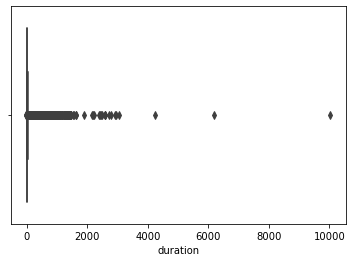

In [8]:
# 3. dropping outliers

# Box Plot
import seaborn as sns
sns.boxplot(jan['duration'])

In [9]:
jan['duration'].describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [10]:
#4  Remove outliers: Keep only records where the duration is between 1 and 60 minutes (inclusive)
filtered_jan = jan[(jan['duration'] >= 1) & (jan['duration'] <= 60)]

# Calculate the fraction of records left
fraction_left = len(filtered_jan) / len(jan)

print(f"Fraction of records left after removing outliers: {fraction_left:.2f}")

Fraction of records left after removing outliers: 0.98


In [11]:
filtered_jan.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'duration'],
      dtype='object')

In [12]:
# 5. what's the dimensionality of this matrix (number of columns)?
dict_ = filtered_jan[['PULocationID','DOLocationID']].to_dict(orient ='record')

# Fit a DictVectorizer
vectorizer = DictVectorizer(sparse=False)
feature_matrix = vectorizer.fit_transform(dict_)

# Print the feature names and the feature matrix
print("Feature names:", vectorizer.get_feature_names_out())
# print("Feature matrix:\n", feature_matrix)
print("Feature matrix shape:", feature_matrix.shape)

/tmp/ipykernel_39019/948998075.py:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  dict_ = filtered_jan[['PULocationID','DOLocationID']].to_dict(orient ='record')


Feature names: ['DOLocationID' 'PULocationID']
Feature matrix shape: (3009173, 2)


In [13]:
# Train a plain linear regression model with default parameters
# Prepare the target variable
target = filtered_jan['duration'].values

# Train a plain linear regression model with default parameters
model = LinearRegression()
model.fit(feature_matrix, target)


# Predict the target variable on the training data
predictions = model.predict(feature_matrix)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(target, predictions))

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 9.835277713631873


## February Data

In [14]:
feb.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.0,0.0,1.0,9.40,2.5,0.00
1,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,-3.0,-1.00,-0.5,0.0,0.0,-1.0,-5.50,0.0,0.00
2,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,3.0,1.00,0.5,0.0,0.0,1.0,5.50,0.0,0.00
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.0,0.0,1.0,74.65,0.0,1.25
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.3,0.0,1.0,25.30,2.5,0.00


In [15]:

# Calculate the duration
feb['duration'] = feb['tpep_dropoff_datetime'] -feb['tpep_pickup_datetime']

# # Convert the duration to total minutes

feb['duration'] = feb['duration'].dt.total_seconds()/60

In [16]:
# Remove outliers: Keep only records where the duration is between 1 and 60 minutes (inclusive)
filtered_feb = feb[(feb['duration'] >= 1) & (feb['duration'] <= 60)]

# Calculate the fraction of records left
fraction_feb = len(filtered_feb) / len(feb)

print(f"Fraction of records left after removing outliers: {fraction_feb:.2f}")

Fraction of records left after removing outliers: 0.98


In [18]:
dict_feb = filtered_feb[['PULocationID','DOLocationID']].to_dict(orient ='record')

# Fit a DictVectorizer
vectorizer = DictVectorizer(sparse=False)
feature_matrix_feb = vectorizer.fit_transform(dict_feb)

# Print the feature names and the feature matrix
print("Feature names:", vectorizer.get_feature_names_out())
# print("Feature matrix:\n", feature_matrix)
print("Feature matrix shape:", feature_matrix_feb.shape)

/tmp/ipykernel_39019/3526530533.py:1: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  dict_feb = filtered_feb[['PULocationID','DOLocationID']].to_dict(orient ='record')


Feature names: ['DOLocationID' 'PULocationID']
Feature matrix shape: (2855951, 2)


In [19]:
# Train a plain linear regression model with default parameters
# Prepare the target variable
target_feb = filtered_feb['duration'].values


# Predict the target variable on the training data
predictions_feb = model.predict(feature_matrix_feb)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(target_feb, predictions_feb))

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 9.963607595829975
